In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import cv2
np.random.seed(42)

In [2]:
############ Load Voronoi Images ###########
data = np.load('voronoi_imgs.npy', allow_pickle=True)
x_train = data[0]
x_tune = data[1]
x_test = data[2]
y_train = data[3]
y_tune = data[4]
y_test = data[5]
y_train_regions = data[6]
y_tune_regions = data[7]
y_test_regions = data[8]
del data

y_train = (y_train/255.0).astype('float32')
y_tune = (y_tune/255.0).astype('float32')
y_test = (y_test/255.0).astype('float32')

x_train = (x_train/255.0).astype('float32')
x_tune = (x_tune/255.0).astype('float32')
x_test = (x_test/255.0).astype('float32')

Number of Voronoi Cells = 13
Number of Voronoi Cells = 11
Number of Voronoi Cells = 10


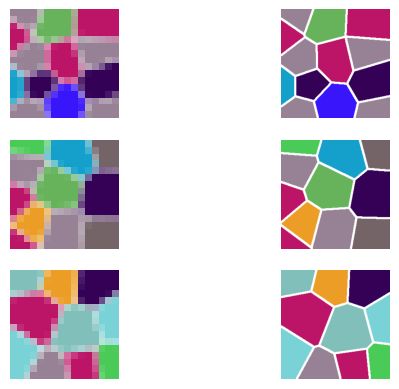

In [3]:
############# Plot Voronoi Low/High Resolution Images ###########
plt.subplot(3,2,1)
plt.imshow(x_train[0])
plt.axis('off')
plt.subplot(3,2,2)
plt.imshow(y_train[0])
plt.axis('off')
print('Number of Voronoi Cells = '+str(y_train_regions[0]))
plt.subplot(3,2,3)
plt.imshow(x_tune[0])
plt.axis('off')
plt.subplot(3,2,4)
plt.imshow(y_tune[0])
plt.axis('off')
print('Number of Voronoi Cells = '+str(y_tune_regions[0]))
plt.subplot(3,2,5)
plt.imshow(x_test[0])
plt.axis('off')
plt.subplot(3,2,6)
plt.imshow(y_test[0])
plt.axis('off')
print('Number of Voronoi Cells = '+str(y_test_regions[0]))

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_generator():
    input_img = layers.Input(shape=(16, 16, 3))  # Input size: 16x16, 3 channels (RGB)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(128, 3, strides=2, padding='same', activation = 'relu')(input_img)
    c2 = layers.Conv2D(256, 3, strides=2, padding='same', activation = 'relu')(c1)
    c3 = layers.Conv2D(512, 3, strides=2, padding='same', activation = 'relu')(c2) 
    
    # bottleneck
    bottleneck = layers.Conv2D(1024, 3, activation='relu', strides=2, padding='same')(c3)      
   
    # Decoder (Upsampling)
    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation = 'relu')(bottleneck)
    d1 = layers.concatenate([d1, c3])

    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation = 'relu')(d1)
    d2 = layers.concatenate([d2, c2])
    
    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation = 'relu')(d2)
    d3 = layers.concatenate([d3, c1])
    
    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation = 'relu')(d3)        
    d5 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation = 'relu')(d4)    
    d6 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation = 'relu')(d5)     
    d7 = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation = 'relu')(d6)
    
    # Output layer
    output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', strides=2, padding='same')(d7)     
    model = models.Model(inputs=input_img, outputs=output)
    model.summary()        
    return model

def build_discriminator():
    input_image = layers.Input(shape=(256,256,3))
    # Encoder (Downsampling)
    d = layers.Conv2D(32, 4, strides=2, padding='same', activation = 'relu')(input_image)    
    d = layers.Conv2D(64, 4, strides=2, padding='same', activation = 'relu')(d) 
    d = layers.Conv2D(128, 4, strides=2, padding='same', activation = 'relu')(d)      
    d = layers.Conv2D(256, 4, strides=2, padding='same', activation = 'relu')(d)    
    d = layers.Conv2D(512, 4, strides=(2,2), padding='same', activation = 'relu')(d)    
    d = layers.Flatten()(d)
    d = layers.Dense(128, activation = 'relu')(d)
    d = layers.Dropout(0.4)(d)
    d = layers.Dense(128, activation = 'relu')(d)    
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(d)
    model = models.Model(input_image, output)
    model.summary()
    return model

from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model
def build_vgg():    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=(256,256,3))    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [14]:
vgg = build_vgg()
vgg.summary()
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [16]:
def build_gan(generator, discriminator, vgg):    
    lr = layers.Input(shape = (16,16,3))    
    
    fake_img = generator(lr) 

    vgg_features = vgg(fake_img)
    
    discriminator.trainable = False
    gan_output = discriminator(fake_img)
    
    gan = models.Model(inputs = lr, outputs = [gan_output,vgg_features])
    return gan

discriminator = build_discriminator()
discriminator.compile(optimizer = 'adam', loss='binary_crossentropy')

generator = build_generator()

gan = build_gan(generator, discriminator, vgg)
gan.compile(optimizer = 'adam', loss=['binary_crossentropy','mse'], loss_weights=[1e-3,1])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      1568      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        32832     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 256)       524544    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 512)         2097664   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0   

In [18]:
def mean_squared_error(true, pred):
    mse_loss = tf.reduce_mean(tf.square(tf.subtract(true,pred)))
    return mse_loss

from tqdm import tqdm
def train(discriminator, generator, gan, vgg, x_train, y_train, x_tune, y_tune, batch_size, n_epochs):
    train_mse = []
    tune_mse = []
    for i in range(n_epochs):
        no_of_iterations = x_train.shape[0]//batch_size		            
        for j in tqdm(range(no_of_iterations)):

            #discriminator training
            idx = np.random.choice(x_train.shape[0],batch_size)  # select images randomly from training data 
            lr = x_train[idx]  # low res training images  
            hr = y_train[idx]  # high res training images       
            fake_image = generator.predict_on_batch(lr) # generator predictions            
            discriminator.trainable = True
            discriminator.train_on_batch(fake_image, np.zeros((batch_size,1)))	# train discriminator on fake images with zero labels
            discriminator.train_on_batch(hr, np.ones((batch_size,1)))           # train discriminator on real images with one labels

            #gan training (generator training)
            discriminator.trainable = False
            idx = np.random.choice(x_train.shape[0],batch_size)   # select images randomly from training data
            lr = x_train[idx]  # low res training images    
            hr = y_train[idx]  # high res training images 
            vgg_features = vgg(hr)            
            gan.train_on_batch(lr , [np.ones((batch_size,1)),vgg_features])  # train gan on fake images with one labels (fooling the descriminator)                              

        predictions = generator.predict_on_batch(x_train) 
        train_mse.append(mean_squared_error(y_train,predictions).numpy())
        
        predictions = generator.predict_on_batch(x_tune) 
        tune_mse.append(mean_squared_error(y_tune,predictions).numpy())
        print('Epoch = '+str(i+1)+', Train MSE = '+str(train_mse[-1])+', Tune MSE = '+str(tune_mse[-1]))
        
        idx = np.random.choice(x_tune.shape[0],1) 
        lr = x_tune[idx]   
        hr = y_tune[idx]        
        fake_img = generator.predict_on_batch(lr)
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(lr[0])
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(hr[0])
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(fake_img[0])
        plt.axis('off')
        plt.draw()
        plt.pause(0.0001)
    return train_mse, tune_mse
    

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:00<00:00, 13.31it/s]


Epoch = 1, Train MSE = 0.07848173, Tune MSE = 0.07943008


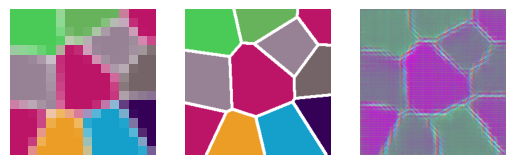

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.97it/s]


Epoch = 2, Train MSE = 0.07336681, Tune MSE = 0.07442286


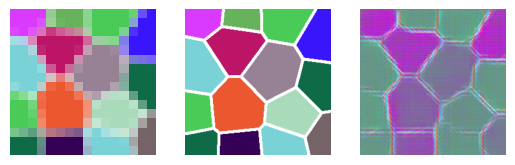

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.88it/s]


Epoch = 3, Train MSE = 0.0704115, Tune MSE = 0.071586065


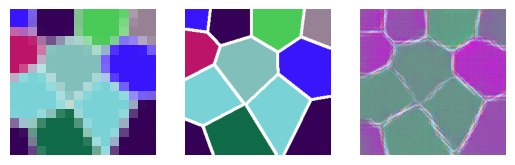

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.92it/s]


Epoch = 4, Train MSE = 0.06699115, Tune MSE = 0.06839747


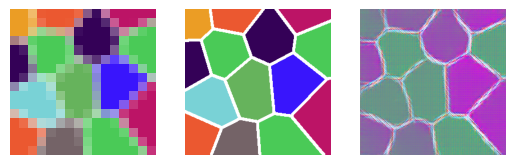

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 5, Train MSE = 0.064067714, Tune MSE = 0.0657593


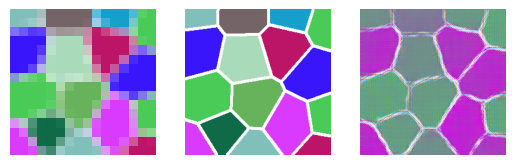

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.07it/s]


Epoch = 6, Train MSE = 0.061896037, Tune MSE = 0.06395868


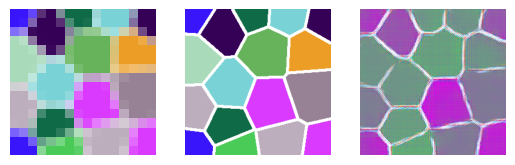

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.04it/s]


Epoch = 7, Train MSE = 0.060424577, Tune MSE = 0.06286798


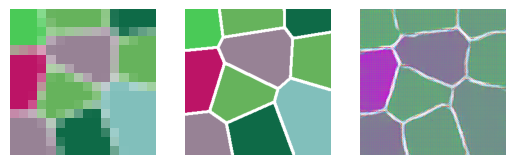

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 8, Train MSE = 0.05917239, Tune MSE = 0.061758943


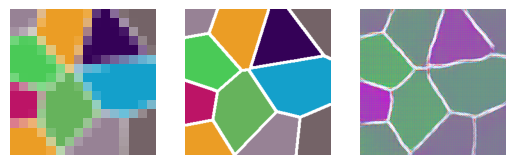

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 9, Train MSE = 0.05741195, Tune MSE = 0.06031432


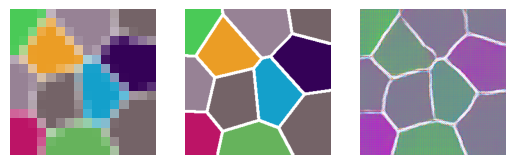

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.01it/s]


Epoch = 10, Train MSE = 0.054308575, Tune MSE = 0.057509746


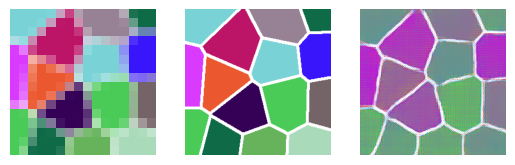

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.08it/s]


Epoch = 11, Train MSE = 0.05055898, Tune MSE = 0.053868376


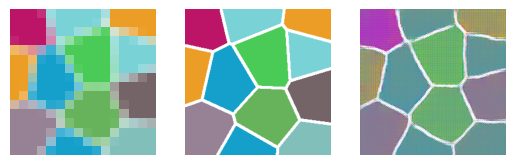

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.05it/s]


Epoch = 12, Train MSE = 0.04808274, Tune MSE = 0.051393256


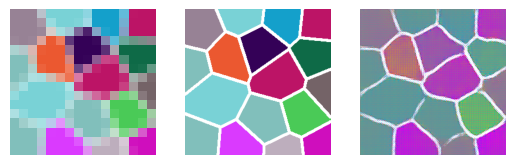

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.26it/s]


Epoch = 13, Train MSE = 0.04596672, Tune MSE = 0.0494482


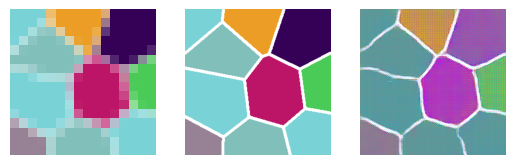

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.99it/s]


Epoch = 14, Train MSE = 0.04503319, Tune MSE = 0.048595726


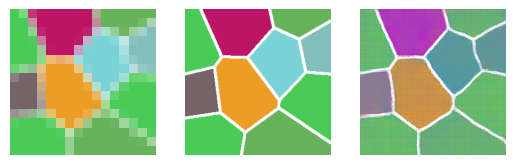

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:51<00:00, 15.66it/s]


Epoch = 15, Train MSE = 0.042421956, Tune MSE = 0.046187304


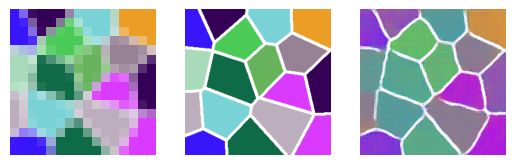

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.01it/s]


Epoch = 16, Train MSE = 0.041626066, Tune MSE = 0.04544336


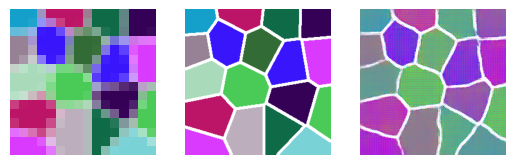

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.09it/s]


Epoch = 17, Train MSE = 0.040842805, Tune MSE = 0.044702582


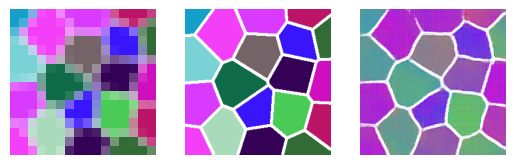

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:48<00:00, 16.45it/s]


Epoch = 18, Train MSE = 0.03955754, Tune MSE = 0.04353571


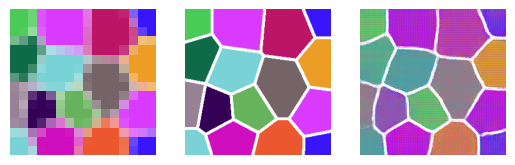

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:48<00:00, 16.51it/s]


Epoch = 19, Train MSE = 0.039093677, Tune MSE = 0.04322111


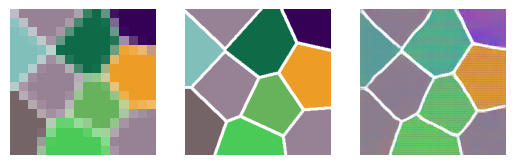

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:48<00:00, 16.51it/s]


Epoch = 20, Train MSE = 0.03821827, Tune MSE = 0.04251232


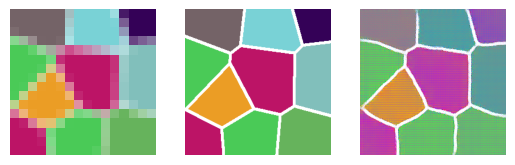

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.28it/s]


Epoch = 21, Train MSE = 0.037403367, Tune MSE = 0.041832376


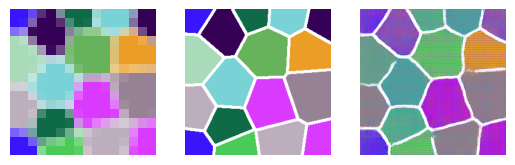

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.72it/s]


Epoch = 22, Train MSE = 0.03698728, Tune MSE = 0.041485105


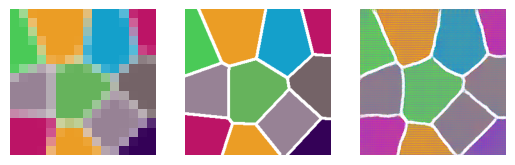

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.32it/s]


Epoch = 23, Train MSE = 0.036779717, Tune MSE = 0.041335296


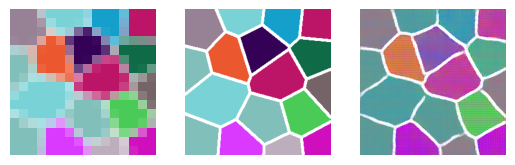

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch = 24, Train MSE = 0.03649937, Tune MSE = 0.041204296


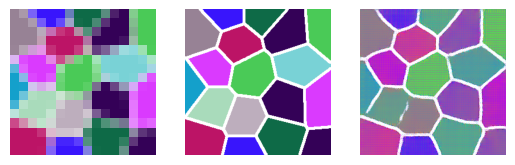

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 25, Train MSE = 0.03625421, Tune MSE = 0.040948603


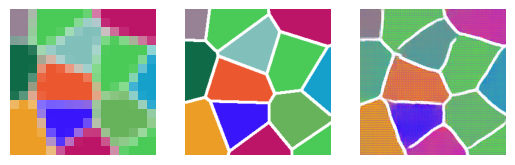

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.91it/s]


Epoch = 26, Train MSE = 0.036067296, Tune MSE = 0.040851034


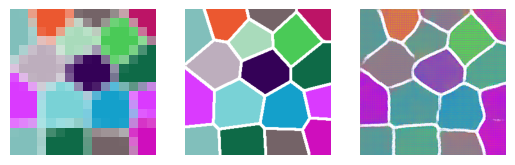

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.82it/s]


Epoch = 27, Train MSE = 0.03566461, Tune MSE = 0.040623583


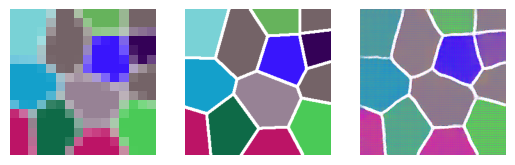

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 28, Train MSE = 0.03563908, Tune MSE = 0.040628612


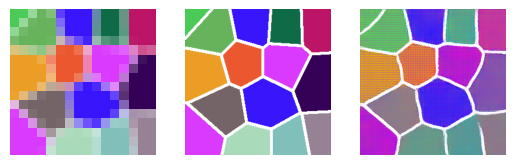

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.26it/s]


Epoch = 29, Train MSE = 0.03548311, Tune MSE = 0.040528882


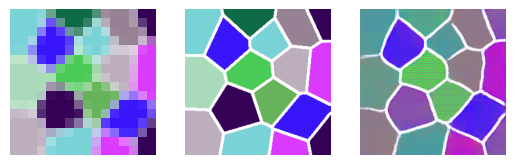

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 30, Train MSE = 0.035074875, Tune MSE = 0.040283334


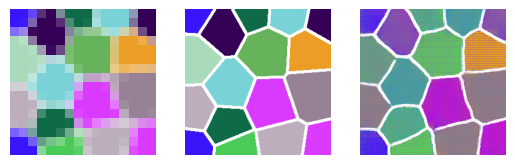

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.21it/s]


Epoch = 31, Train MSE = 0.03535623, Tune MSE = 0.04043712


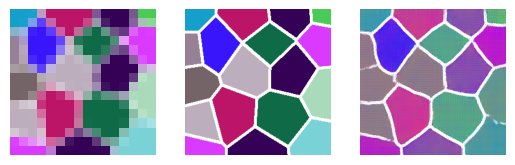

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch = 32, Train MSE = 0.03489863, Tune MSE = 0.04017831


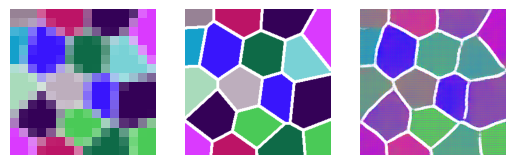

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.08it/s]


Epoch = 33, Train MSE = 0.034791674, Tune MSE = 0.040023934


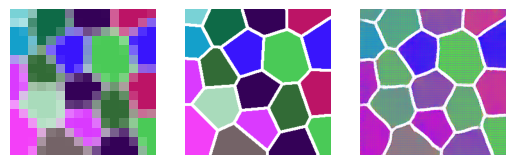

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch = 34, Train MSE = 0.03509852, Tune MSE = 0.04039093


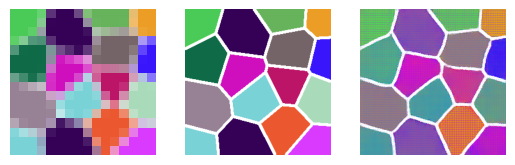

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 35, Train MSE = 0.03456372, Tune MSE = 0.040030126


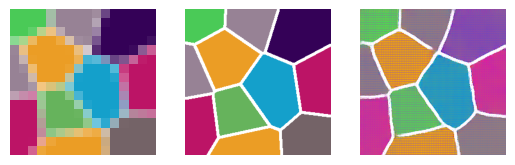

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.08it/s]


Epoch = 36, Train MSE = 0.034764692, Tune MSE = 0.040007483


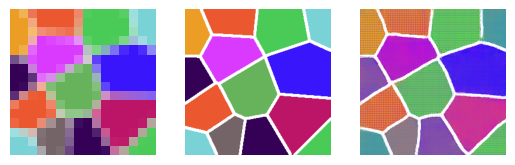

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.96it/s]


Epoch = 37, Train MSE = 0.034720093, Tune MSE = 0.040102072


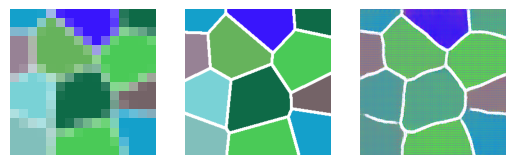

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 38, Train MSE = 0.03435649, Tune MSE = 0.039996516


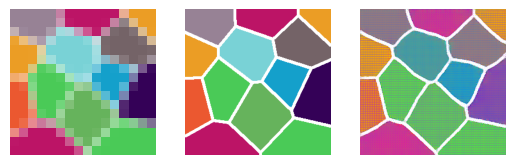

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.23it/s]


Epoch = 39, Train MSE = 0.034454316, Tune MSE = 0.040013872


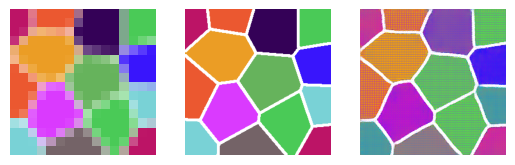

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 40, Train MSE = 0.034122515, Tune MSE = 0.039820395


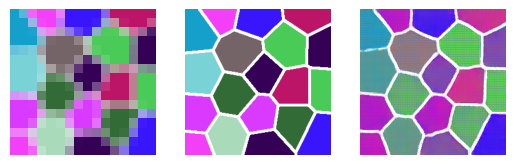

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.98it/s]


Epoch = 41, Train MSE = 0.03410709, Tune MSE = 0.039751258


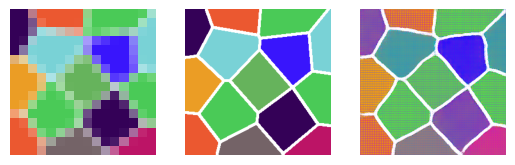

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.21it/s]


Epoch = 42, Train MSE = 0.034172546, Tune MSE = 0.039859094


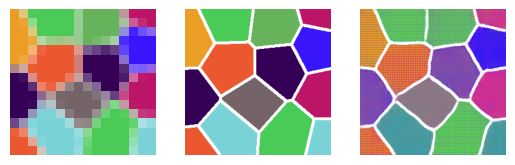

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.23it/s]


Epoch = 43, Train MSE = 0.03446044, Tune MSE = 0.040056102


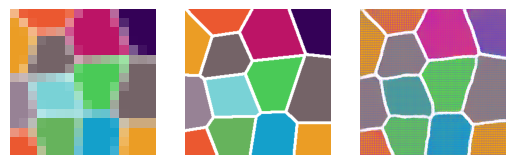

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.17it/s]


Epoch = 44, Train MSE = 0.0342085, Tune MSE = 0.039953835


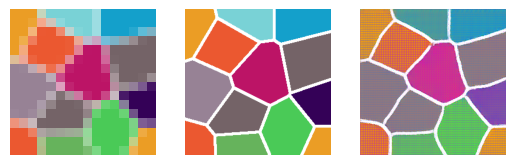

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.14it/s]


Epoch = 45, Train MSE = 0.034525737, Tune MSE = 0.040240973


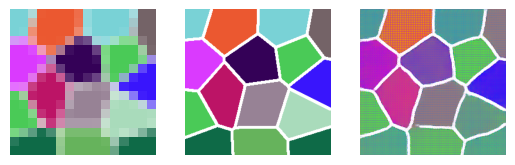

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.97it/s]


Epoch = 46, Train MSE = 0.034080252, Tune MSE = 0.039867233


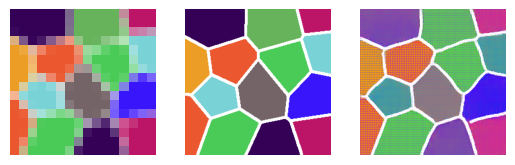

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 47, Train MSE = 0.03427061, Tune MSE = 0.040041346


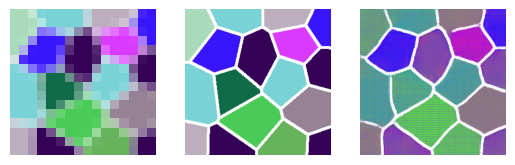

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.20it/s]


Epoch = 48, Train MSE = 0.034395095, Tune MSE = 0.040106617


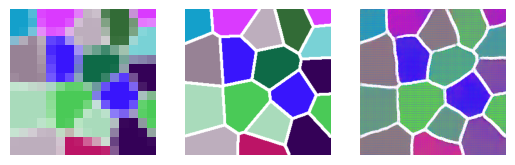

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.16it/s]


Epoch = 49, Train MSE = 0.034303144, Tune MSE = 0.040242907


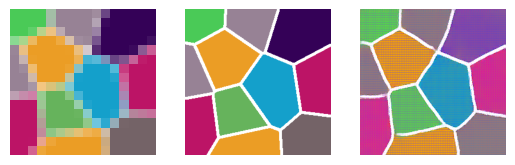

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 50, Train MSE = 0.034363646, Tune MSE = 0.04023091


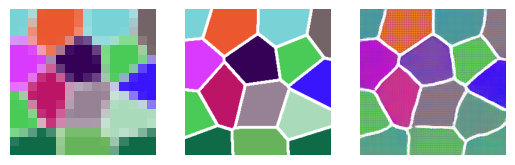

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch = 51, Train MSE = 0.034474354, Tune MSE = 0.04042151


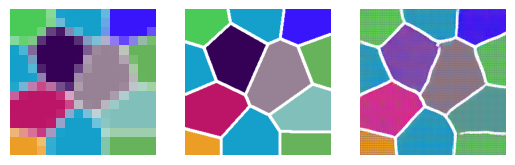

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.07it/s]


Epoch = 52, Train MSE = 0.03454866, Tune MSE = 0.040449407


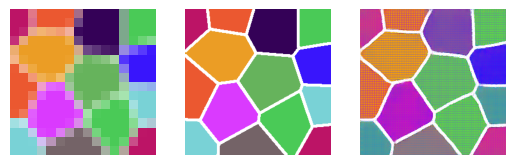

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.26it/s]


Epoch = 53, Train MSE = 0.03445512, Tune MSE = 0.04052294


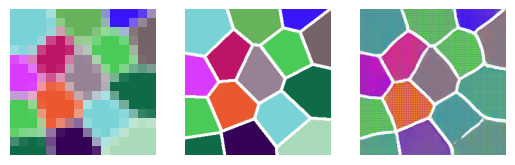

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.86it/s]


Epoch = 54, Train MSE = 0.034565575, Tune MSE = 0.040555242


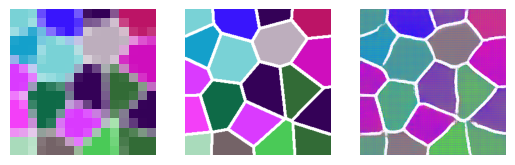

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.99it/s]


Epoch = 55, Train MSE = 0.034519613, Tune MSE = 0.04050671


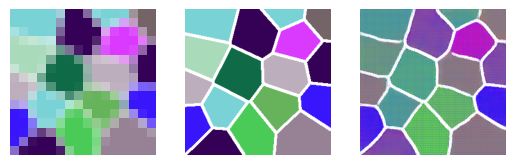

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.17it/s]


Epoch = 56, Train MSE = 0.034574497, Tune MSE = 0.04055163


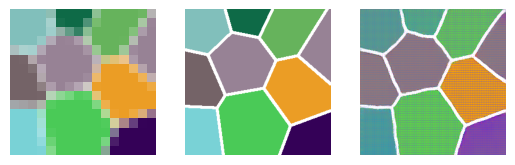

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.88it/s]


Epoch = 57, Train MSE = 0.034619417, Tune MSE = 0.040677957


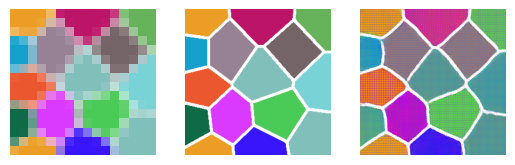

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:52<00:00, 15.23it/s]


Epoch = 58, Train MSE = 0.03447732, Tune MSE = 0.04057866


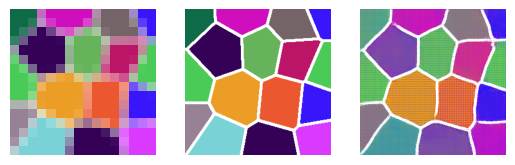

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 59, Train MSE = 0.034377553, Tune MSE = 0.0405036


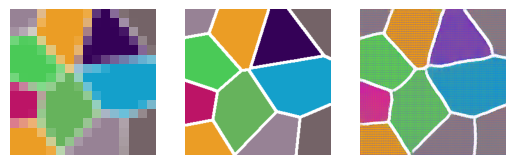

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 60, Train MSE = 0.034490123, Tune MSE = 0.040539637


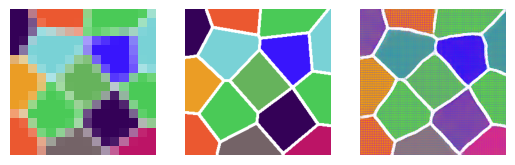

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch = 61, Train MSE = 0.034313176, Tune MSE = 0.040447265


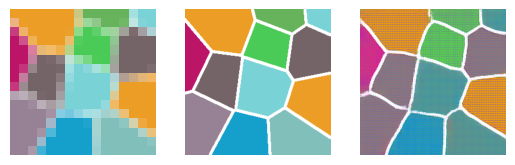

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.16it/s]


Epoch = 62, Train MSE = 0.034437973, Tune MSE = 0.040537354


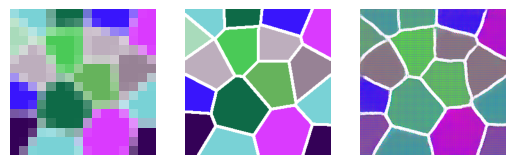

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.24it/s]


Epoch = 63, Train MSE = 0.034363583, Tune MSE = 0.04060049


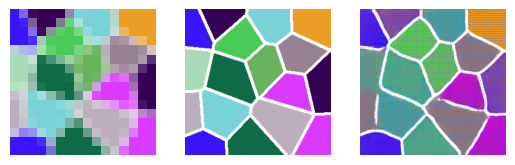

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 64, Train MSE = 0.03448999, Tune MSE = 0.04049424


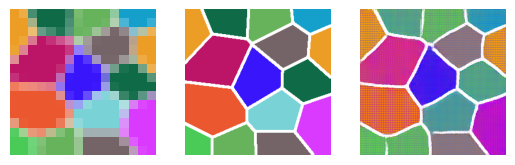

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.15it/s]


Epoch = 65, Train MSE = 0.034326985, Tune MSE = 0.04058334


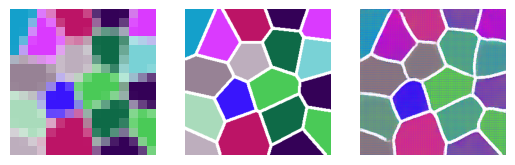

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.14it/s]


Epoch = 66, Train MSE = 0.0343261, Tune MSE = 0.04050747


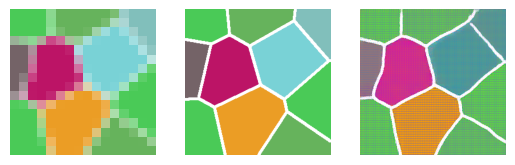

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch = 67, Train MSE = 0.034084942, Tune MSE = 0.040426224


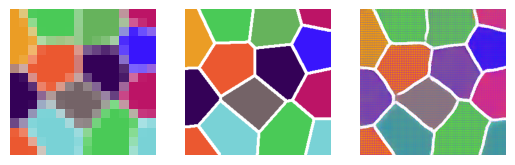

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 68, Train MSE = 0.034327246, Tune MSE = 0.040581085


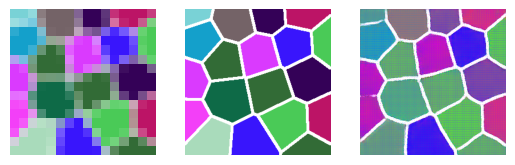

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 69, Train MSE = 0.034556344, Tune MSE = 0.04083814


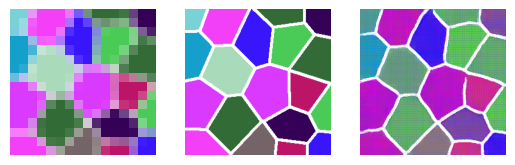

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 70, Train MSE = 0.0343638, Tune MSE = 0.04068143


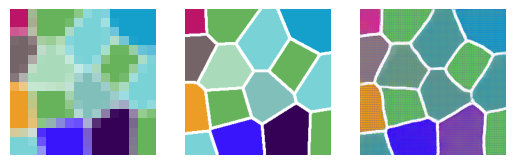

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.14it/s]


Epoch = 71, Train MSE = 0.03442407, Tune MSE = 0.040722422


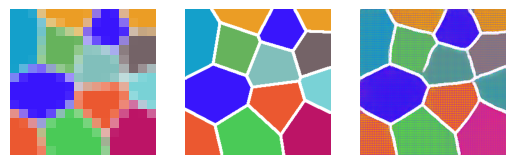

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.15it/s]


Epoch = 72, Train MSE = 0.0343044, Tune MSE = 0.040604595


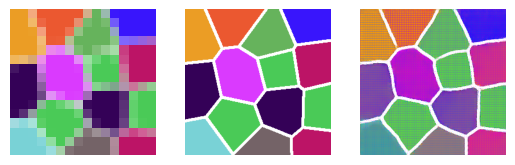

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.14it/s]


Epoch = 73, Train MSE = 0.034303334, Tune MSE = 0.040667113


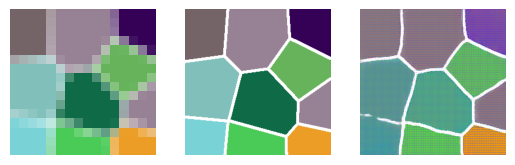

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.16it/s]


Epoch = 74, Train MSE = 0.034338076, Tune MSE = 0.040721845


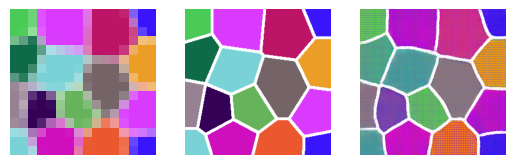

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.17it/s]


Epoch = 75, Train MSE = 0.03431844, Tune MSE = 0.040681604


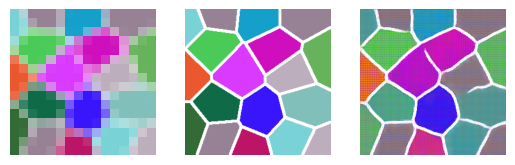

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch = 76, Train MSE = 0.034417216, Tune MSE = 0.040737446


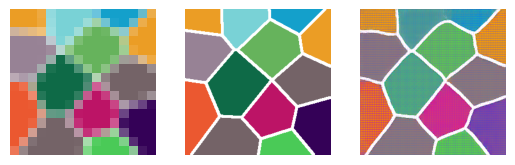

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.17it/s]


Epoch = 77, Train MSE = 0.034156892, Tune MSE = 0.040403277


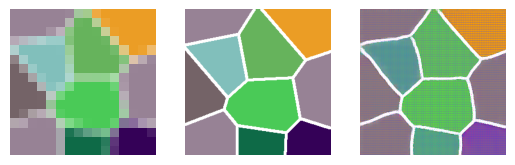

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch = 78, Train MSE = 0.034232497, Tune MSE = 0.040686842


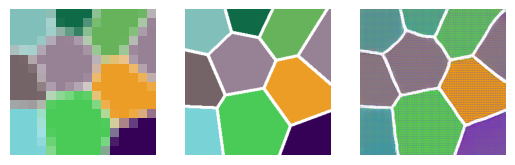

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.20it/s]


Epoch = 79, Train MSE = 0.034562174, Tune MSE = 0.04097532


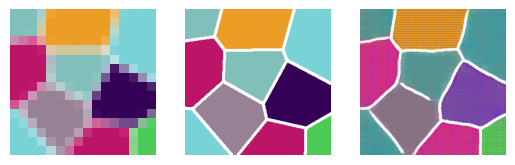

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 80, Train MSE = 0.03429483, Tune MSE = 0.040755916


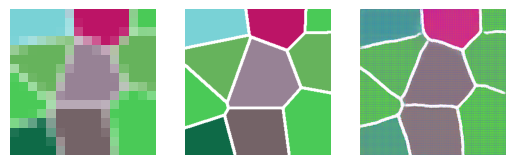

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch = 81, Train MSE = 0.03439863, Tune MSE = 0.040610693


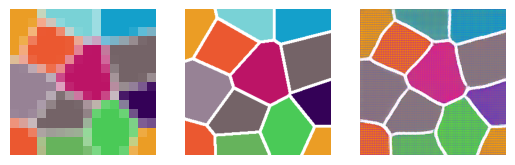

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.17it/s]


Epoch = 82, Train MSE = 0.033981353, Tune MSE = 0.040431995


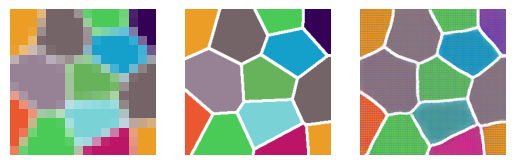

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.20it/s]


Epoch = 83, Train MSE = 0.033911, Tune MSE = 0.040370602


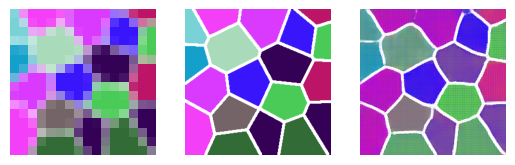

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.03it/s]


Epoch = 84, Train MSE = 0.033142667, Tune MSE = 0.03950243


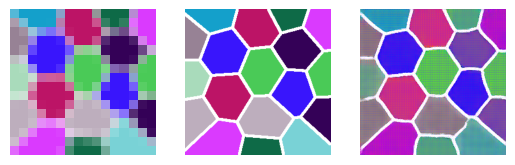

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.14it/s]


Epoch = 85, Train MSE = 0.03288237, Tune MSE = 0.039237592


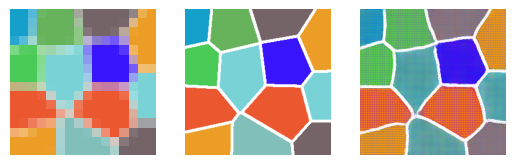

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 86, Train MSE = 0.032306075, Tune MSE = 0.03878363


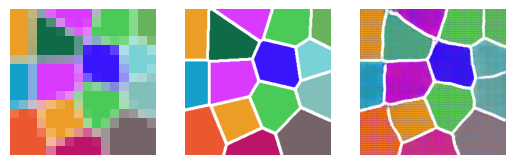

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.18it/s]


Epoch = 87, Train MSE = 0.031899747, Tune MSE = 0.038413033


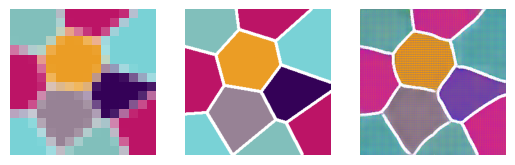

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.03it/s]


Epoch = 88, Train MSE = 0.03176744, Tune MSE = 0.0382646


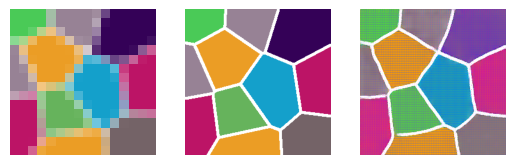

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.02it/s]


Epoch = 89, Train MSE = 0.031623375, Tune MSE = 0.038025975


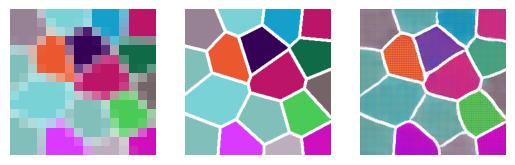

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.83it/s]


Epoch = 90, Train MSE = 0.030575842, Tune MSE = 0.037034195


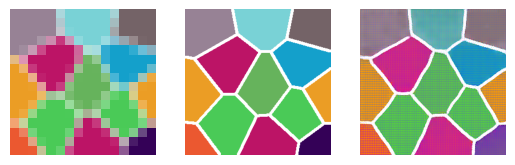

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:52<00:00, 15.19it/s]


Epoch = 91, Train MSE = 0.030449161, Tune MSE = 0.036933865


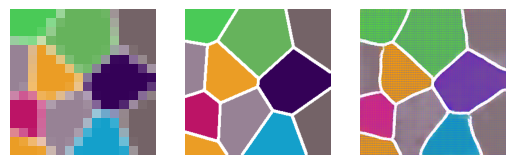

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:51<00:00, 15.44it/s]


Epoch = 92, Train MSE = 0.030216163, Tune MSE = 0.03668449


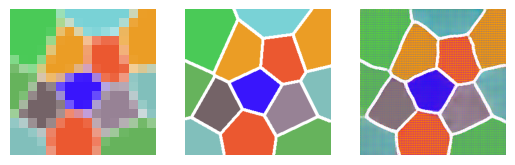

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.91it/s]


Epoch = 93, Train MSE = 0.02981826, Tune MSE = 0.03633353


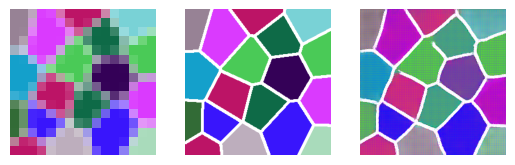

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.30it/s]


Epoch = 94, Train MSE = 0.029562658, Tune MSE = 0.03614338


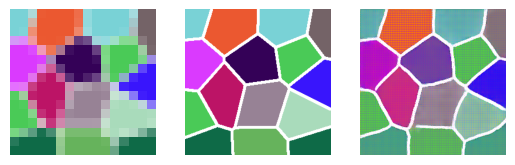

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:48<00:00, 16.37it/s]


Epoch = 95, Train MSE = 0.029650036, Tune MSE = 0.03616561


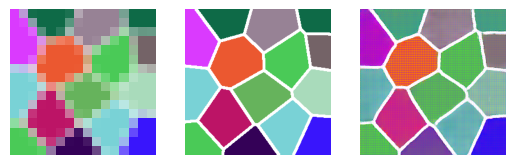

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.09it/s]


Epoch = 96, Train MSE = 0.0290446, Tune MSE = 0.035635266


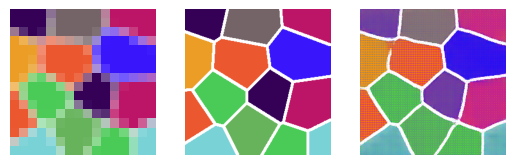

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.20it/s]


Epoch = 97, Train MSE = 0.028789809, Tune MSE = 0.03548571


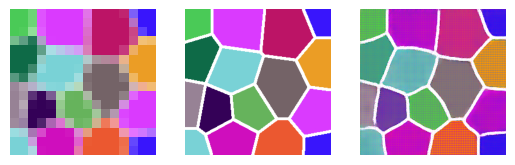

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.05it/s]


Epoch = 98, Train MSE = 0.028907767, Tune MSE = 0.03549453


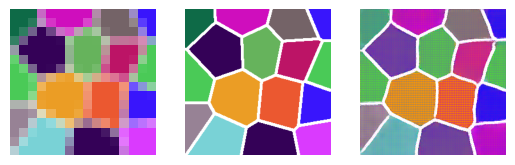

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:49<00:00, 16.14it/s]


Epoch = 99, Train MSE = 0.028842986, Tune MSE = 0.03542149


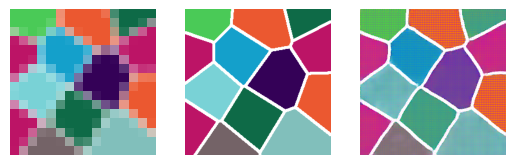

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 15.99it/s]


Epoch = 100, Train MSE = 0.02822904, Tune MSE = 0.034769416


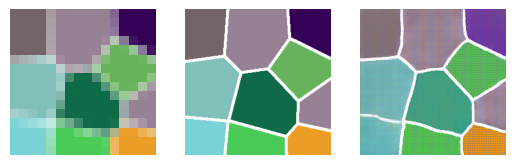

In [19]:
train_mse, tune_mse = train(discriminator, generator, gan, vgg, x_train, y_train, x_tune, y_tune, batch_size = 1, n_epochs = 100)

(0.0, 0.1)

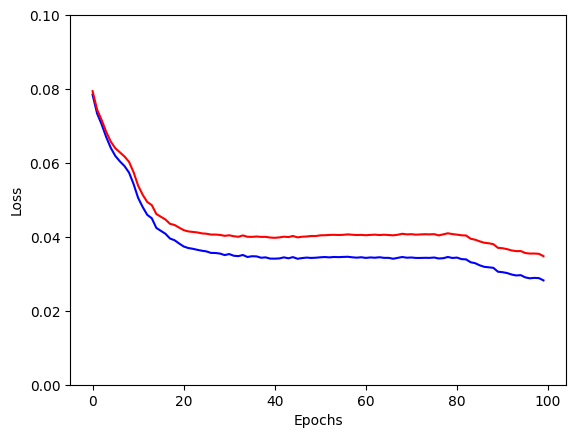

In [21]:
plt.plot(train_mse, c = 'b')
plt.plot(tune_mse, c = 'r')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([0,0.1])

In [22]:
predictions = generator.predict(x_test)

ssim_all = [ssim(y_test[i].squeeze(),predictions[i].squeeze(), channel_axis=-1, data_range=1) for i in range(100)]
print('Average SSIM = '+str(np.mean(ssim_all)))
print('Min SSIM = '+str(np.min(ssim_all)))
print('Max SSIM = '+str(np.max(ssim_all)))
print('STD SSIM = '+str(np.std(ssim_all)))
print('SSIM = '+str(np.round(np.mean(ssim_all),2))+'['+str(np.round(np.percentile(ssim_all,2.5),2))+', '+str(np.round(np.percentile(ssim_all,97.5),2))+'] 95% CI')


Average SSIM = 0.23845579
Min SSIM = 0.17067228
Max SSIM = 0.28986964
STD SSIM = 0.022989351
SSIM = 0.24[0.19, 0.28] 95% CI


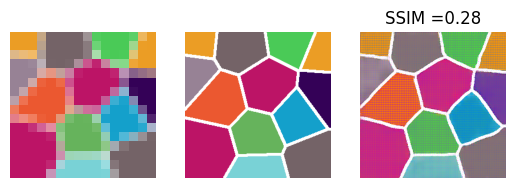

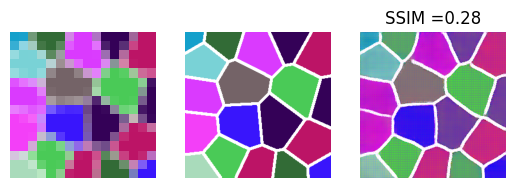

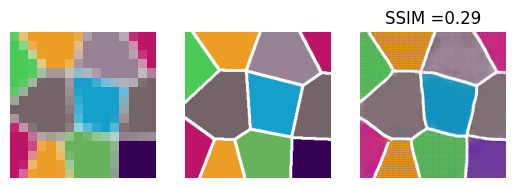

In [23]:
#### 3 best images #####
idx = np.argpartition(ssim_all, -3)[-3:]
for i in idx:  
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(y_test[i])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title('SSIM ='+str(np.round(ssim_all[i],2)))

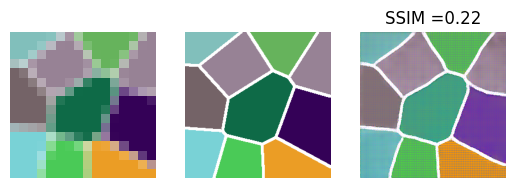

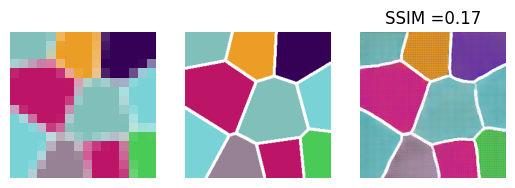

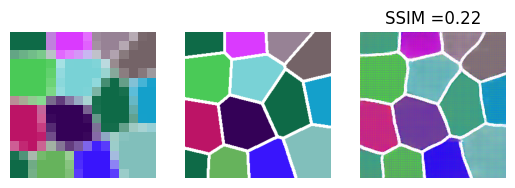

In [24]:
#### 3 worst images #####
idx = np.argpartition(ssim_all, -3)[:3]
for i in idx:  
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(y_test[i])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title('SSIM ='+str(np.round(ssim_all[i],2)))